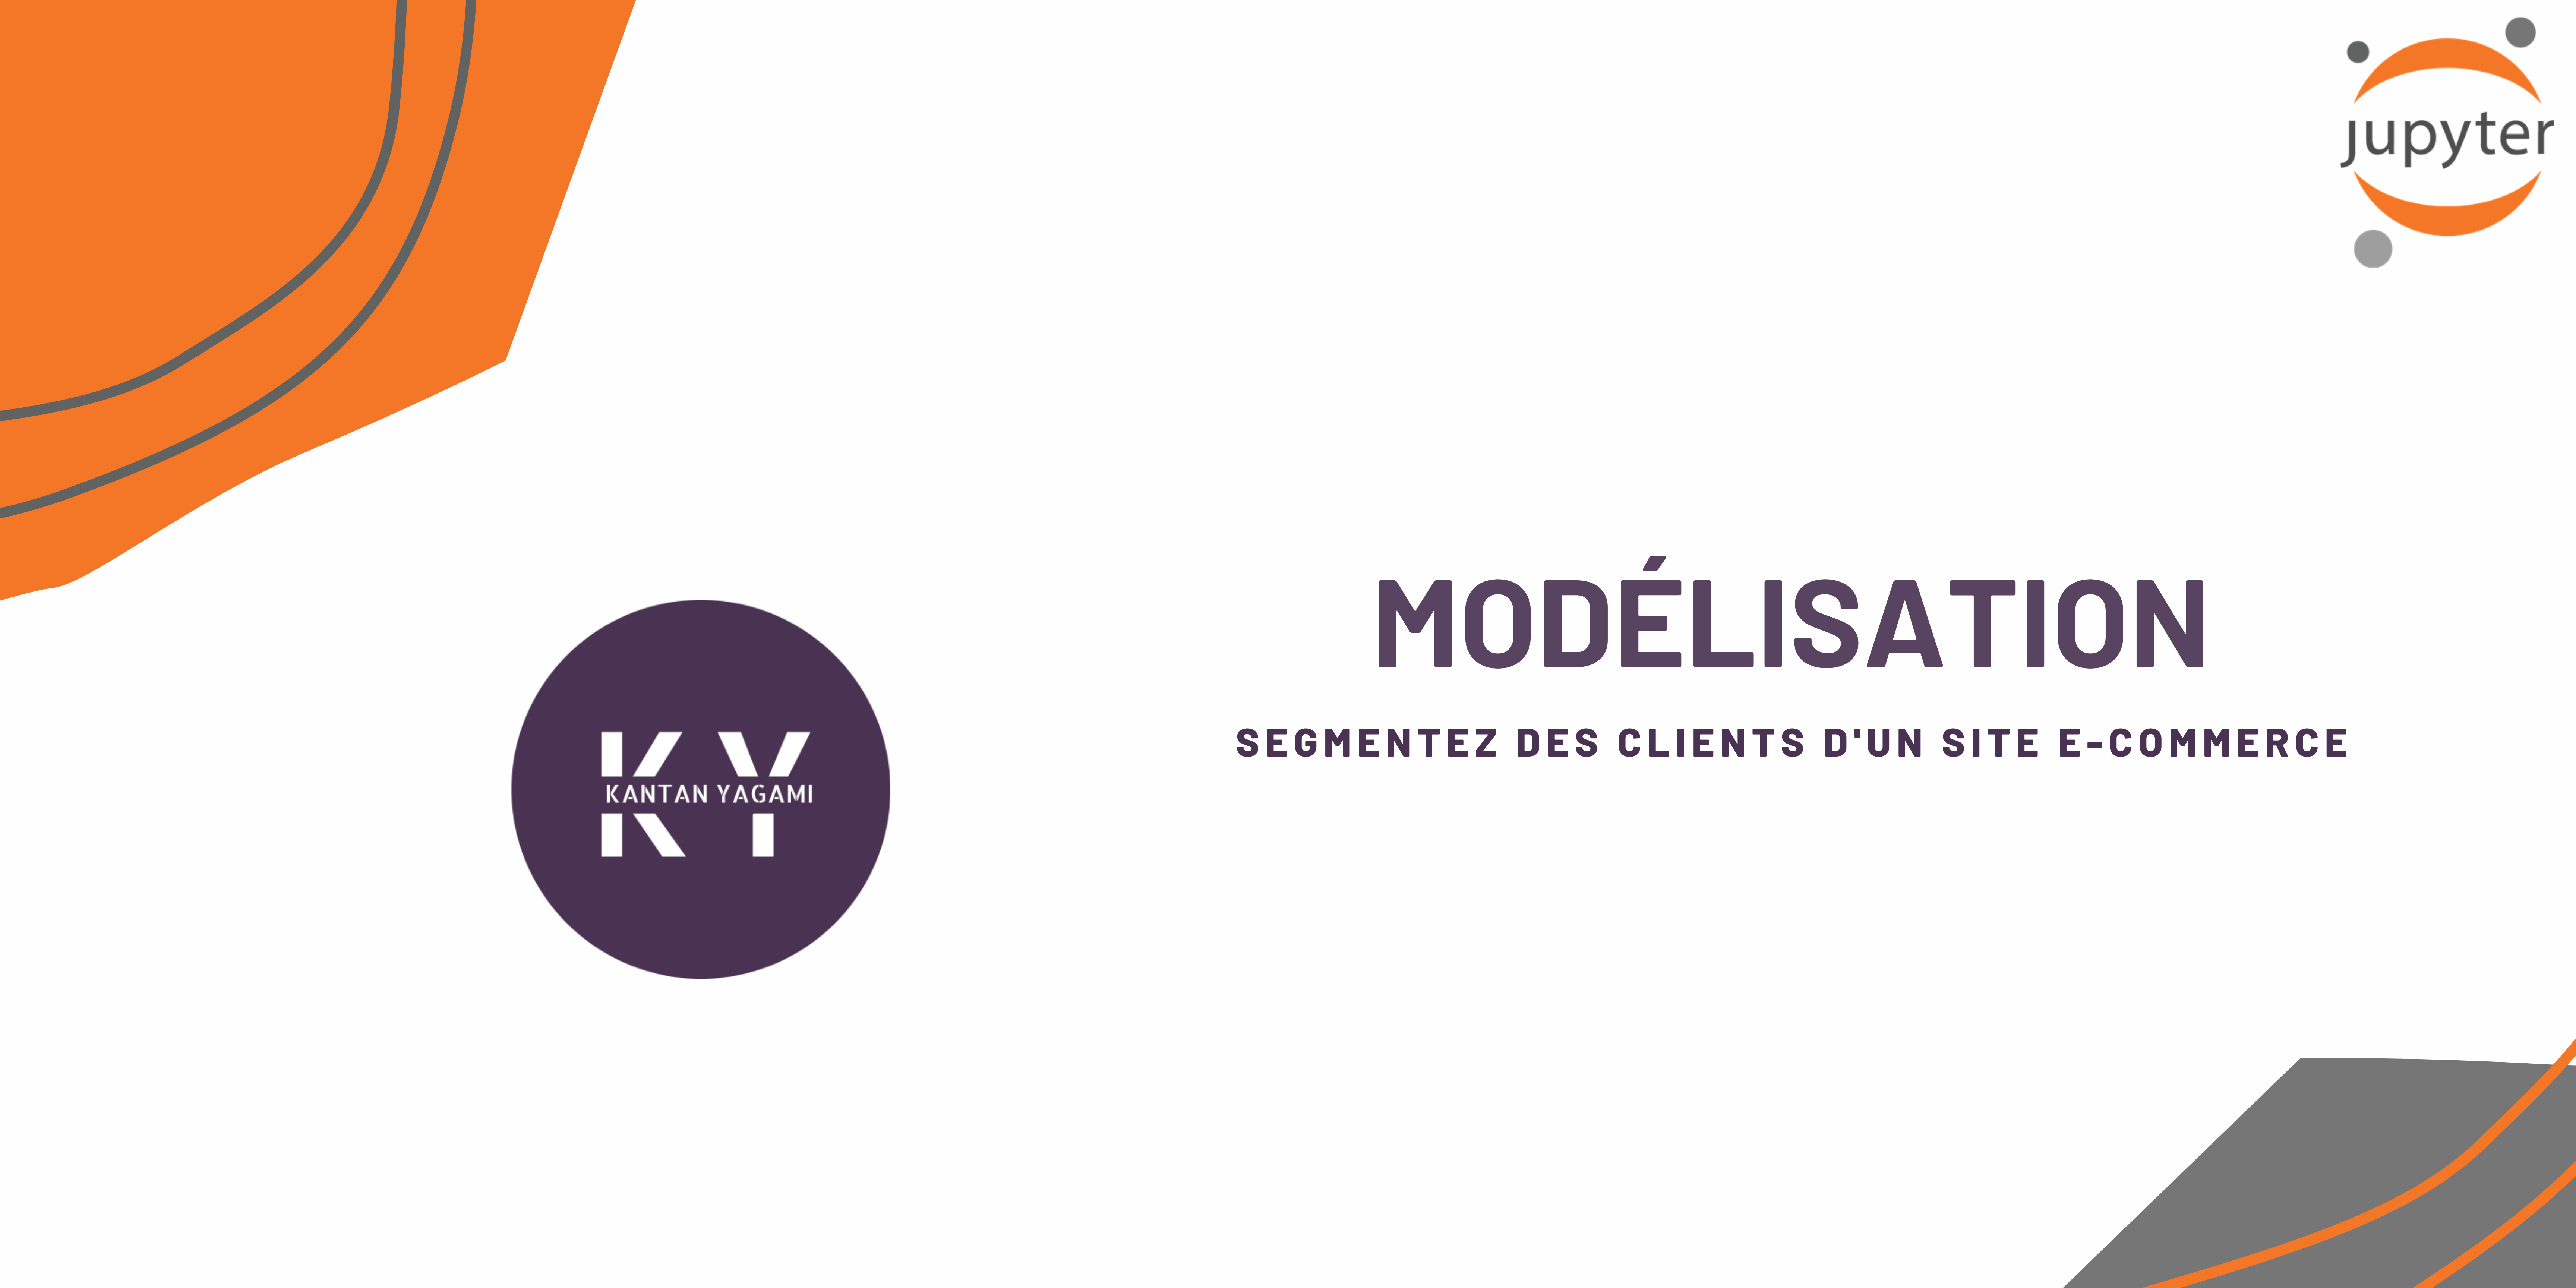

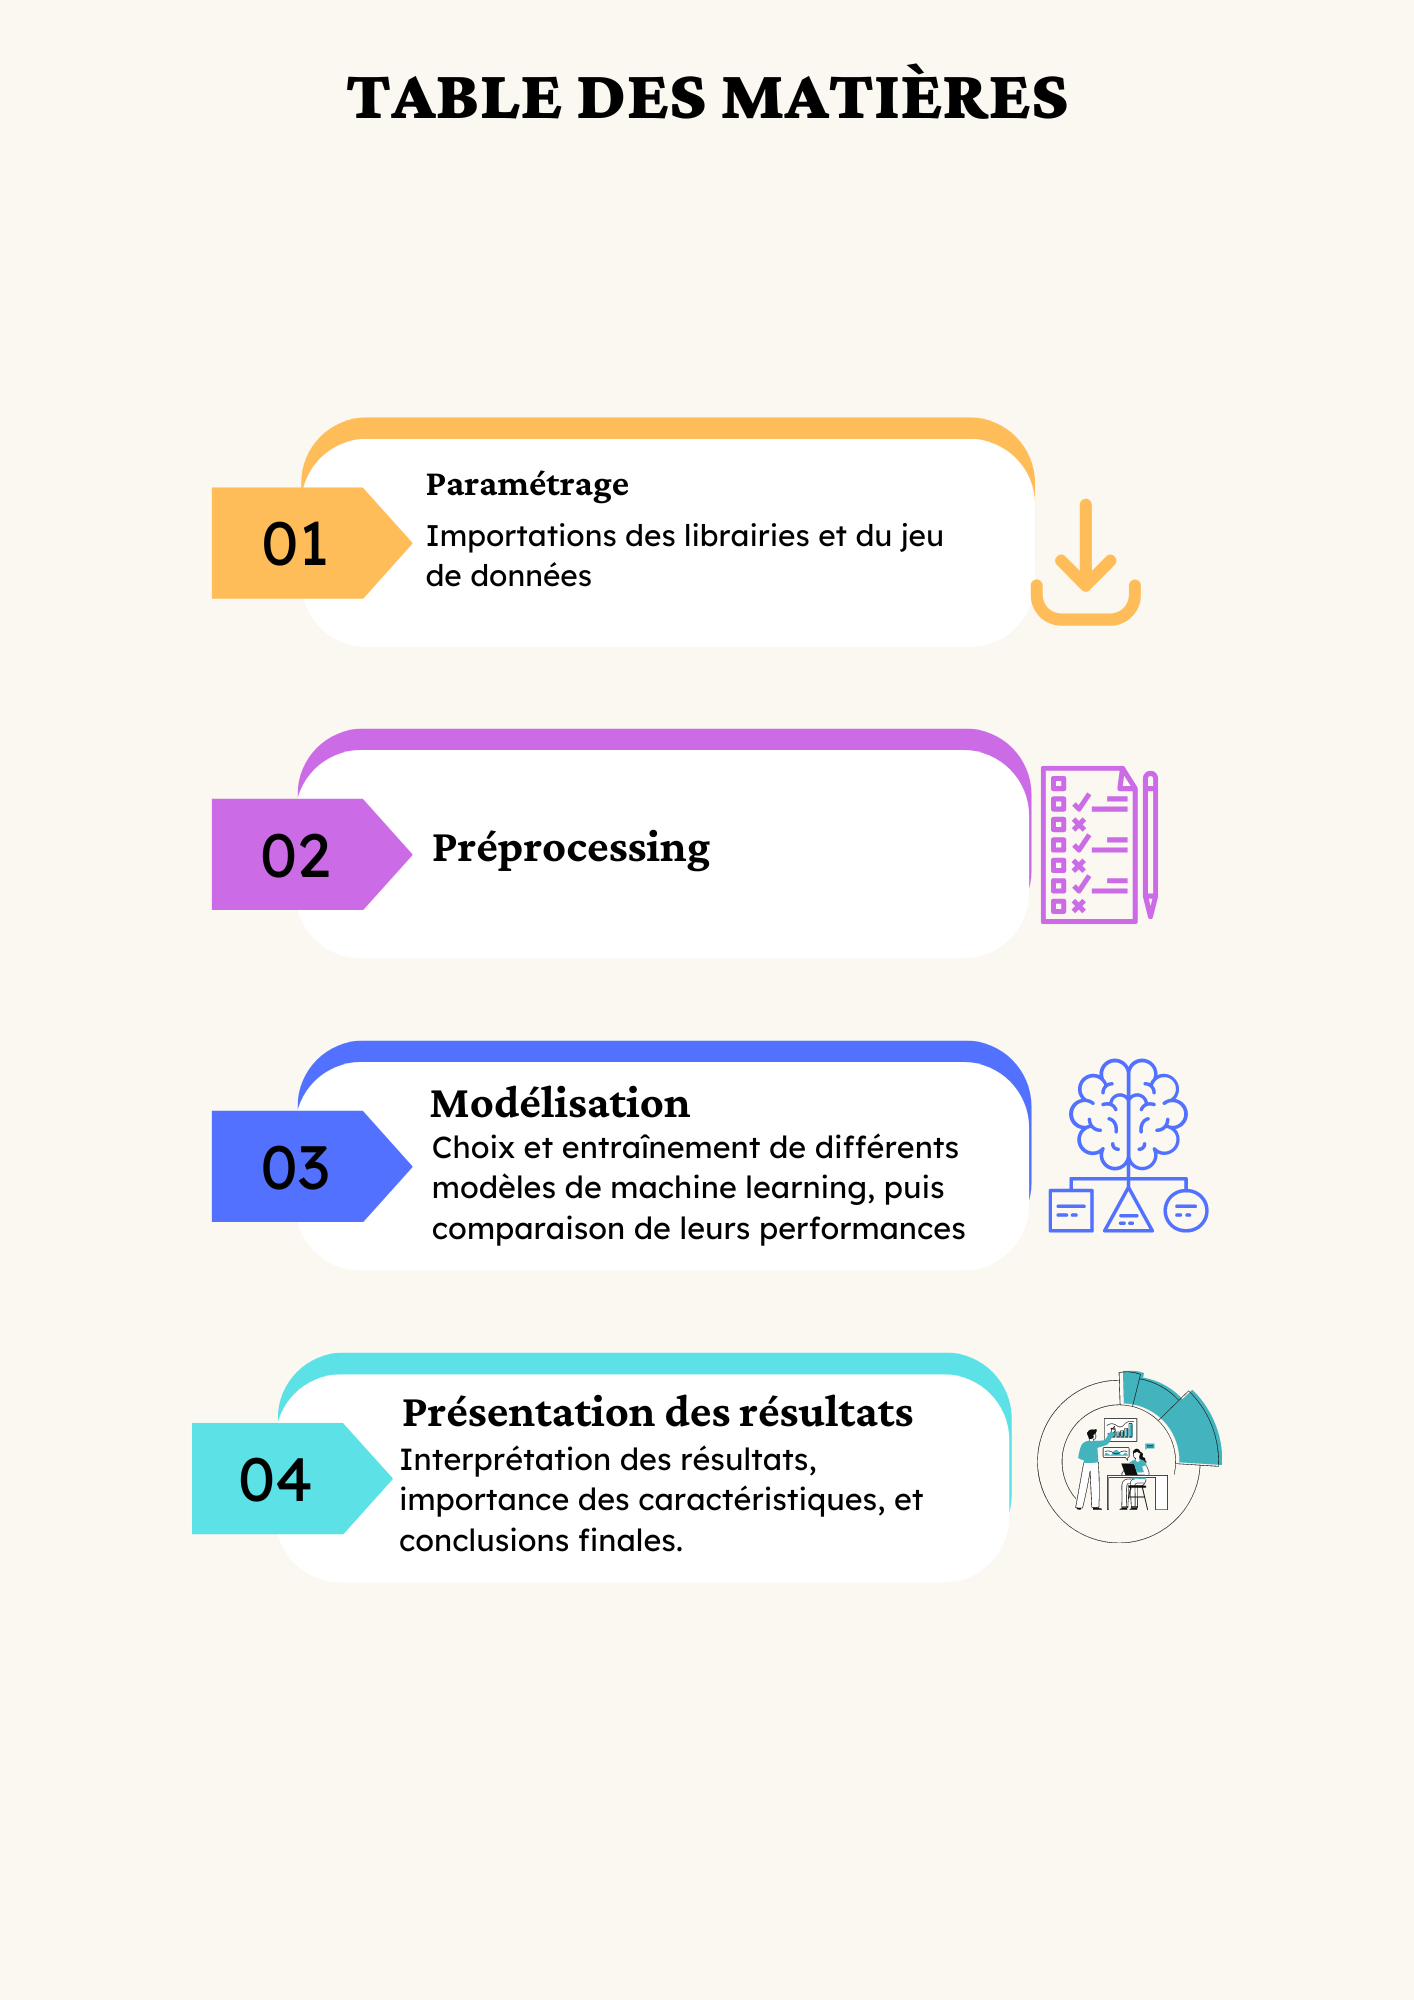

## Paramétrage

### Importations

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import time

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, TSNE, LocallyLinearEmbedding

from kneed import KneeLocator


In [2]:
data = pd.read_csv('./Data/Datasets/df_data_clean.csv')

## Préprocessing

In [3]:
data.dtypes

customer_unique_id     object
Importance               bool
Recency                 int64
Frequency               int64
Rising                float64
Review_average        float64
dtype: object

### Normalisation

#### Tests de normalité

In [4]:
from scipy import stats
import pandas as pd

# Niveau de signification (alpha)
alpha = 0.05

# Liste pour stocker les résultats
results = []

# Variables quantitatives à tester
quantitative_columns = ['Review_average', 'Rising', 'Frequency', 'Recency']

for column in quantitative_columns:
    # Récupérer les valeurs de la variable
    values = data[column].dropna()

    # Effectuer les tests de normalité pour chaque variable
    shapiro_test = stats.shapiro(values)
    ks_test = stats.kstest(values, 'norm', N=len(values))
    ad_test = stats.anderson(values, dist='norm')
    dagostino_test = stats.normaltest(values)

    # Ajouter les résultats à la liste pour chaque test et variable
    results.append({
        'Variable': column,
        'Shapiro-Wilk': shapiro_test[1] > alpha,
        'Kolmogorov-Smirnov': ks_test.pvalue > alpha,
        'Anderson-Darling': any(ad_test.statistic < crit_val for crit_val in ad_test.critical_values),
        'D\'Agostino-Pearson': dagostino_test.pvalue > alpha,
    })

# Création d'un DataFrame avec les résultats
test_results = pd.DataFrame(results)

test_results


/home/nexus/venv/lib/python3.6/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Variable,Shapiro-Wilk,Kolmogorov-Smirnov,Anderson-Darling,D'Agostino-Pearson
0,Review_average,False,False,False,False
1,Rising,False,False,False,False
2,Frequency,False,False,False,False
3,Recency,False,False,False,False


Les résultats des tests de normalité indiquent que pour toutes les variables testées aucune ne suit une distribution normale.

En conséquence, nous allons envisager la normalisation de ces caractéristiques.

#### Comparaison des méthodes de normalisation

In [5]:
# Colonnes quantitatives à normaliser
quantitative_columns = ['Review_average', 'Rising', 'Frequency', 'Recency']

# Cloner le DataFrame pour créer des copies
df_min_max = data.copy()
df_standard = data.copy()
df_robust = data.copy()

# Appliquer différentes méthodes de normalisation uniquement sur les colonnes spécifiées
scaler_min_max = MinMaxScaler()
df_min_max[quantitative_columns] = scaler_min_max.fit_transform(df_min_max[quantitative_columns])

scaler_standard = StandardScaler()
df_standard[quantitative_columns] = scaler_standard.fit_transform(df_standard[quantitative_columns])

scaler_robust = RobustScaler()
df_robust[quantitative_columns] = scaler_robust.fit_transform(df_robust[quantitative_columns])

# Initialisation d'un DataFrame vide pour stocker les résultats
results_df = pd.DataFrame(columns=["Normalisation", "Silhouette Score", "Davies-Bouldin Index", "Temps de Calcul"])

# Appliquer l'algorithme de clustering à chaque version normalisée des données
for name, dataset in tqdm(zip(["Min-Max", "Standard", "Robust"], [df_min_max, df_standard, df_robust]), total=3, desc="Traitement"):
    start_time = time.time()  # Commencer à mesurer le temps
    
    # Utiliser KMeans comme exemple d'algorithme de clustering
    kmeans = KMeans(n_clusters=3) 
    labels = kmeans.fit_predict(dataset[quantitative_columns])  # Utiliser seulement les colonnes normalisées pour le clustering
    
    # Évaluer la performance de chaque méthode de normalisation
    silhouette_avg = silhouette_score(dataset[quantitative_columns], labels)
    davies_bouldin = davies_bouldin_score(dataset[quantitative_columns], labels)
    
    end_time = time.time()  # Fin de la mesure du temps
    temps_calcul = end_time - start_time  # Calculer le temps passé
    
    # Ajouter les résultats dans le DataFrame
    results_df = results_df.append({
        "Normalisation": name,
        "Silhouette Score": silhouette_avg,
        "Davies-Bouldin Index": davies_bouldin,
        "Temps de Calcul": temps_calcul
    }, ignore_index=True)

# Afficher les résultats
results_df

Traitement: 100%|██████████| 3/3 [10:02<00:00, 200.98s/it]


,Normalisation,Silhouette Score,Davies-Bouldin Index,Temps de Calcul
0,Min-Max,0.459039,0.772232,194.893888
1,Standard,0.412250,0.964251,204.038569
2,Robust,0.502429,0.779281,203.990261


Notre exploration des méthodes de normalisation a révélé des insights précieux sur leur impact sur la performance des modèles de clustering appliqués à la segmentation client selon les critères RFM. 

En utilisant les scores de silhouette et le Davies-Bouldin Index comme métriques d'évaluation, conjointement avec l'analyse du temps de calcul pour chaque approche, nous avons pu établir une comparaison empirique des effets de chaque méthode de normalisation sur l'efficacité du clustering.

- Robust Scaling s'est distingué comme la méthode la plus performante en termes de score de silhouette (0.502429), indiquant une meilleure cohérence interne des clusters formés et une adéquation significative des clients à leurs segments respectifs. Ce résultat suggère que Robust Scaling est particulièrement efficace pour traiter les données RFM, qui peuvent présenter des valeurs aberrantes ou une distribution asymétrique, en minimisant leur impact sur la segmentation.


- Bien que Min-Max Scaling ait offert une séparation de cluster légèrement inférieure en comparaison, comme indiqué par un Davies-Bouldin Index de 0.772465, cette méthode a néanmoins produit des clusters bien définis et distincts, soulignant son utilité dans des scénarios où une distinction claire entre les segments est recherchée.


- Standard Scaling, malgré un score de silhouette inférieur (0.412250) et un Davies-Bouldin Index plus élevé (0.964251), reste une option viable dans des contextes où les données suivent une distribution normale. Cependant, pour notre cas spécifique de segmentation client RFM, cette méthode semble être la moins adaptée des trois, probablement en raison de sa sensibilité aux valeurs aberrantes.

En termes de temps de calcul, les différences entre les méthodes sont marginales, ce qui indique que le choix de la méthode de normalisation peut être basé principalement sur la qualité du clustering sans compromis significatif sur la performance computationnelle.

En conclusion, Robust Scaling émerge comme la méthode de normalisation la plus prometteuse pour notre tâche de segmentation client RFM.

Elle offre un équilibre optimal entre la cohérence interne des clusters et la capacité à gérer efficacement les valeurs aberrantes, ce qui est crucial dans l'analyse comportementale des clients.

#### Application de la normalisation

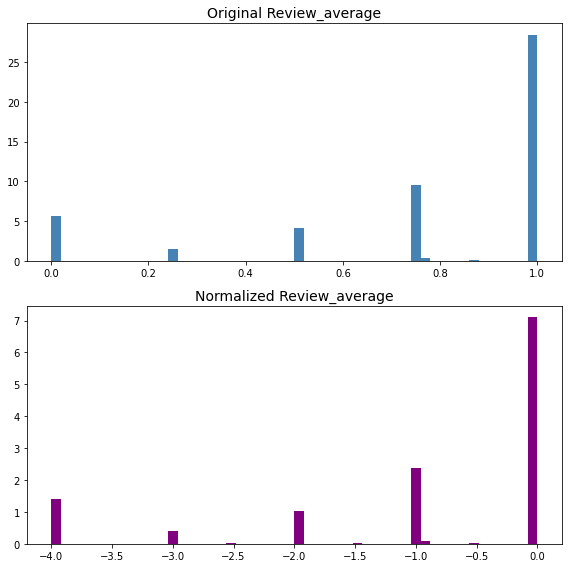

In [6]:
# Colonnes à normaliser avec Robust Scaling
columns_to_scale = ['Review_average', 'Rising', 'Frequency', 'Recency']

# Création d'une copie des données originales pour la visualisation
data_original = data.copy()

# Initialisation du RobustScaler
scaler = RobustScaler()

# Application du Robust Scaling sur les colonnes spécifiées de 'data'
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Configuration de la visualisation
fig, axes = plt.subplots(nrows=2, figsize=(8, 8))

# Affichage de la donnée originale 'Review_average'
axes[0].hist(data_original['Review_average'].dropna(), bins=50, color='steelblue', density=True, edgecolor='none')
axes[0].set_title('Original Review_average', fontsize=14)

# Affichage de la donnée normalisée 'Review_average'
axes[1].hist(data['Review_average'], bins=50, color='purple', density=True, edgecolor='none')
axes[1].set_title('Normalized Review_average', fontsize=14)

# Ajustement des subplots pour la lisibilité
plt.tight_layout()
plt.show()

### Échantillonnage des données

In [7]:
# Échantillonnage aléatoire sans stratification qui contient 20% des données
sample, _ = train_test_split(data, test_size=0.8, random_state=42)

In [8]:
sample.head()

,customer_unique_id,Importance,Recency,Frequency,Rising,Review_average
74397,c60c5563690f2a27a76f4d8ba53c2a85,False,-0.222222,0.0,-0.544971,0.0
45823,79d64050de51f4f2c5280e88ba96c864,False,0.854701,0.0,0.492401,-2.0
44830,77426f7a06e493a618f5eec875ee7450,False,0.329060,0.0,0.006395,0.0
19856,34b02e69444e6e159c83d7d6936fb216,False,0.128205,0.0,-0.216012,-1.0
42974,72257c3a06b3f5851d40c70240f4e322,False,0.799145,0.0,-0.212607,0.0


### Encoding des variables catégorielles

Pour notre variable booléenne Importance, nous avons choisi l'encodage One-Hot parce que, pour les variables catégorielles nominales sans ordre inhérent, comme True ou False dans notre cas, l'encodage One-Hot est recommandé. 

Cela permet de traiter chaque catégorie équitablement sans supposer un ordre entre elles, contrairement au Label Encoding qui est mieux adapté pour les variables catégorielles ordinales, où l'ordre des catégories a de l'importance.

In [9]:
# Convertir la colonne 'Importance' en type de données catégorielles dans l'échantillon
sample['Importance'] = sample['Importance'].astype('category')

# Initialisation de OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Reshape nécessaire car fit_transform attend un 2D array
importance_encoded = encoder.fit_transform(sample[['Importance']])

columns_names = encoder.get_feature_names(['Importance'])

# Remplacer la colonne 'Importance' dans le dataframe 'sample' par les colonnes encodées
sample = pd.concat([sample.drop(columns=['Importance']), pd.DataFrame(importance_encoded, index=sample.index, columns=columns_names)], axis=1)

# Afficher le résultat
sample

/home/nexus/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,customer_unique_id,Recency,Frequency,Rising,Review_average,Importance_False,Importance_True
74397,c60c5563690f2a27a76f4d8ba53c2a85,-0.222222,0.0,-0.544971,0.0,1.0,0.0
45823,79d64050de51f4f2c5280e88ba96c864,0.854701,0.0,0.492401,-2.0,1.0,0.0
44830,77426f7a06e493a618f5eec875ee7450,0.329060,0.0,0.006395,0.0,1.0,0.0
19856,34b02e69444e6e159c83d7d6936fb216,0.128205,0.0,-0.216012,-1.0,1.0,0.0
42974,72257c3a06b3f5851d40c70240f4e322,0.799145,0.0,-0.212607,0.0,1.0,0.0
...,...,...,...,...,...,...,...
6265,108b1a74b02d1e998850c39d7a7e9150,-0.440171,0.0,-0.595299,0.0,1.0,0.0
54886,92515a627915c69367e6e389ef331262,-0.585470,0.0,-0.322066,0.0,1.0,0.0
76820,cc70a7c16df0bb4b2fa17403d4ec3769,-0.824786,0.0,-0.518811,0.0,1.0,0.0
860,024c132534a98479e42a33027e3ad2e2,-0.491453,0.0,0.074329,-1.0,1.0,0.0


### Réduction dimensionnelle 

#### Comparaison des méthodes de reduction de dimensionnalité

In [10]:
# Sélectionner uniquement les colonnes numériques de 'sample'
data_numerique = sample.select_dtypes(include=[np.number])

# Standardiser les données
X = StandardScaler().fit_transform(data_numerique)

methods = {
    "PCA": PCA(n_components=2),
    "Kernel PCA": KernelPCA(n_components=2, kernel='rbf', gamma=15),
    "Isomap": Isomap(n_components=2),
    "LLE": LocallyLinearEmbedding(n_components=2),
    "t-SNE": TSNE(n_components=2, perplexity=30, n_iter=300)
}

# Appliquer chaque méthode et calculer le score de silhouette
silhouette_scores = {}
for name, method in methods.items():
    X_reduced = method.fit_transform(X)
    cluster_labels = KMeans(n_clusters=4, random_state=0).fit_predict(X_reduced)
    score = silhouette_score(X_reduced, cluster_labels)
    silhouette_scores[name] = score
    print(f"{name} Silhouette Score: {score}")

# Identifier la méthode avec le score de silhouette le plus élevé
best_method = max(silhouette_scores, key=silhouette_scores.get)
print(f"\nLa méthode recommandée est : {best_method} avec un score de silhouette de {silhouette_scores[best_method]:.2f}")

PCA Silhouette Score: 0.5622015328624331
Kernel PCA Silhouette Score: 0.7577758512305083
Isomap Silhouette Score: 0.6683052201065294
LLE Silhouette Score: 0.7407969080223582
t-SNE Silhouette Score: 0.3652634024620056

La méthode recommandée est : Kernel PCA avec un score de silhouette de 0.76


#### Test du nombre de composante optimal pour la reduction dimensionnelle avec Kernel PCA

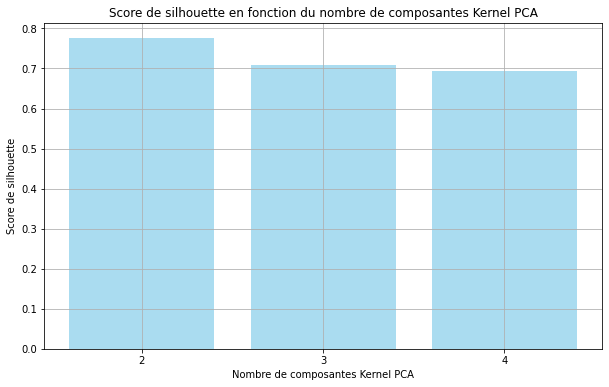

Meilleur score de silhouette: 0.78
Nombre de composantes Kernel PCA optimal: 2


In [11]:
data_numerique = sample[['Review_average', 'Rising', 'Frequency', 'Recency']]

# Plage du nombre de composantes à tester
n_components_range = [2, 3, 4] 

# Initialiser la liste pour stocker les scores de silhouette
silhouette_scores = []

for n_components in n_components_range:
    # Appliquer Kernel PCA sur les données
    kpca = KernelPCA(n_components=n_components, kernel='rbf', gamma=15, random_state=42)
    X_kpca = kpca.fit_transform(data_numerique)
    
    # Appliquer le clustering avec KMeans
    kmeans = KMeans(n_clusters=4, random_state=42)
    labels = kmeans.fit_predict(X_kpca)
    
    # Calculer le score de silhouette
    score = silhouette_score(X_kpca, labels)
    silhouette_scores.append(score)

# Tracer la courbe du score de silhouette
plt.figure(figsize=(10, 6))
plt.bar(n_components_range, silhouette_scores, color='skyblue', align='center', alpha=0.7)
plt.title('Score de silhouette en fonction du nombre de composantes Kernel PCA')
plt.xlabel('Nombre de composantes Kernel PCA')
plt.ylabel('Score de silhouette')
plt.xticks(n_components_range)
plt.grid(True)
plt.show()

# Imprimer le meilleur score et le nombre de composantes associé
best_score_index = np.argmax(silhouette_scores)
print(f"Meilleur score de silhouette: {silhouette_scores[best_score_index]:.2f}")
print(f"Nombre de composantes Kernel PCA optimal: {n_components_range[best_score_index]}")

#### Application de la reduction dimensionnelle

In [12]:
# Application de la réduction dimensionnelle avec Kernel PCA
kpca_optimal = KernelPCA(n_components=2, kernel='rbf', gamma=15, random_state=42)
X_kpca_optimal = kpca_optimal.fit_transform(data_numerique)

# Création d'un nouveau DataFrame pour les données réduites
data_kpca_reduced = pd.DataFrame(X_kpca_optimal, columns=['KernelPCA1', 'KernelPCA2'])

# Afficher les premières lignes du DataFrame réduit
data_kpca_reduced.head()

,KernelPCA1,KernelPCA2
0,0.514249,0.339027
1,-0.048098,-0.028639
2,-0.147291,0.161222
3,-0.083663,-0.051461
4,-0.195500,0.001516


## Modélisation

### Clustering Hiérarchique

#### Détermination du Nombre Optimal de Clusters

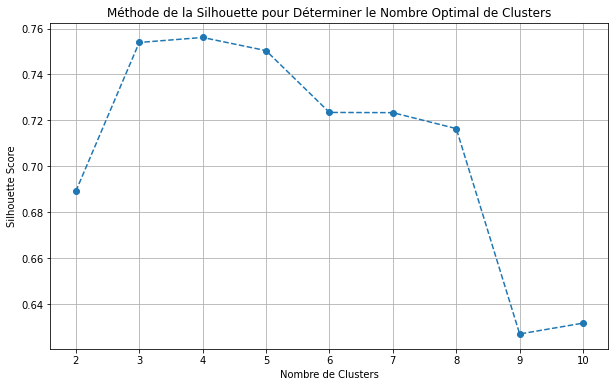

Nombre optimal de clusters : 4


In [13]:
# Créez une liste pour stocker les valeurs du silhouette score
silhouette_scores = []

# Testez différents nombres de clusters de 2 à 10
for n_clusters in range(2, 11):
    # Appliquez le clustering hiérarchique
    hc = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    cluster_labels = hc.fit_predict(data_kpca_reduced)
    
    # Calculez le silhouette score pour ce nombre de clusters
    silhouette_avg = silhouette_score(data_kpca_reduced, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Tracez le silhouette score en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Méthode de la Silhouette pour Déterminer le Nombre Optimal de Clusters')
plt.grid(True)
plt.show()

# Trouvez le nombre optimal de clusters en utilisant le silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # +2 car nous avons commencé à partir de 2 clusters
print(f'Nombre optimal de clusters : {optimal_num_clusters}')


#### Implémentation du Clustering Hiérarchique

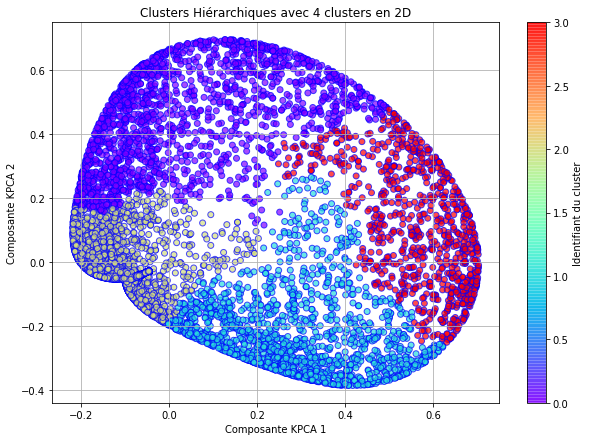

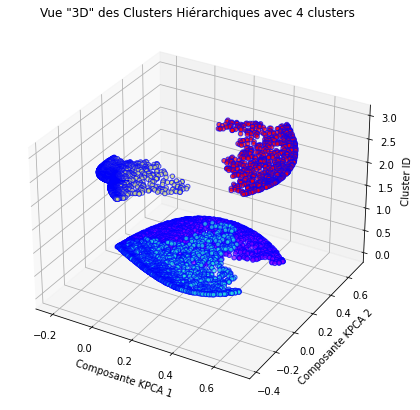

Score de silhouette pour les clusters hiérarchiques : 0.76


In [14]:
# Appliquez le clustering hiérarchique avec le nombre optimal de clusters trouvé précédemment
hc_optimal = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
hc_labels = hc_optimal.fit_predict(data_kpca_reduced)

# Ajoutez les labels de clustering hiérarchique comme une nouvelle colonne dans 'sample'
sample['Cluster_HC'] = hc_labels

# Visualisation 2D
plt.figure(figsize=(10, 7))
plt.scatter(data_kpca_reduced.iloc[:, 0], data_kpca_reduced.iloc[:, 1], c=hc_labels, cmap='rainbow', alpha=0.7, edgecolors='b')
plt.title('Clusters Hiérarchiques avec 4 clusters en 2D')
plt.xlabel('Composante KPCA 1')
plt.ylabel('Composante KPCA 2')
plt.colorbar(label='Identifiant du cluster')
plt.grid(True)
plt.show()

# Création d'un scatter plot "3D"
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_kpca_reduced.iloc[:, 0], data_kpca_reduced.iloc[:, 1], hc_labels, c=hc_labels, cmap='rainbow', alpha=0.7, edgecolors='b')
ax.set_title('Vue "3D" des Clusters Hiérarchiques avec 4 clusters')
ax.set_xlabel('Composante KPCA 1')
ax.set_ylabel('Composante KPCA 2')
ax.set_zlabel('Cluster ID')
plt.show()

# Calculer le score de silhouette pour la configuration optimale
silhouette_avg_optimal = silhouette_score(data_kpca_reduced, hc_labels)
print(f'Score de silhouette pour les clusters hiérarchiques : {silhouette_avg_optimal:.2f}')


#### Interprétation des résultats

L'application du clustering hiérarchique sur les données réduites par Kernel PCA a abouti à un score de silhouette de 0.76.

Ce résultat suggère une bonne cohésion au sein des clusters et une séparation raisonnable entre eux.

Les visualisations en deux et trois dimensions révèlent des groupes distincts, mais avec une distribution qui semble moins linéaire et plus dispersée que celle observée avec LLE.

### K-Means

#### Détermination du Nombre Optimal de Clusters

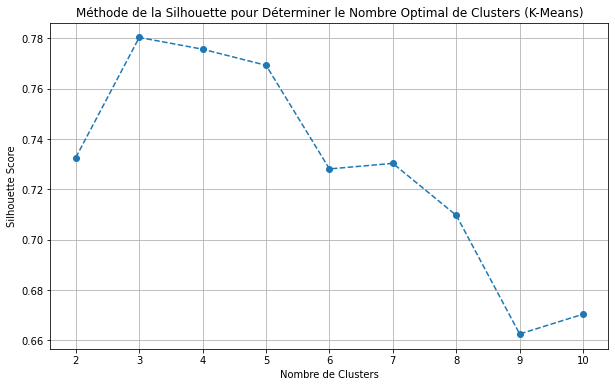

Nombre optimal de clusters (K-Means) : 3


In [15]:
# liste pour stocker les valeurs du silhouette score
silhouette_scores = []

# Testez différents nombres de clusters de 2 à 10
for n_clusters in range(2, 11):
    # Appliquez le clustering K-Means sur les données réduites par Kernel PCA
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_kpca_reduced)
    
    # Calculez le silhouette score pour ce nombre de clusters
    silhouette_avg = silhouette_score(data_kpca_reduced, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Tracez le silhouette score en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Méthode de la Silhouette pour Déterminer le Nombre Optimal de Clusters (K-Means)')
plt.grid(True)
plt.show()

# Trouvez le nombre optimal de clusters en utilisant le silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # +2 car nous avons commencé à partir de 2 clusters
print(f'Nombre optimal de clusters (K-Means) : {optimal_num_clusters}')

#### Implémentation avec K-Means

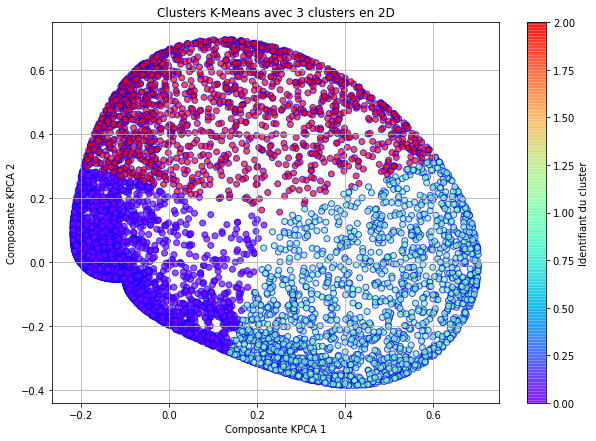

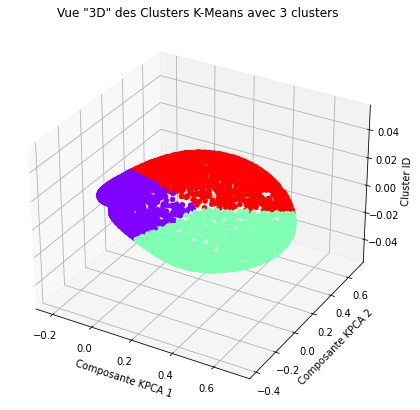

Score de silhouette pour K-Means avec 3 clusters: 0.78


In [16]:
# Appliquez le clustering K-Means avec le nombre optimal de clusters sur les données réduites
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(data_kpca_reduced)
sample['Cluster_KMeans'] = kmeans_labels

# Visualisation 2D
plt.figure(figsize=(10, 7))
plt.scatter(data_kpca_reduced.iloc[:, 0], data_kpca_reduced.iloc[:, 1], c=kmeans_labels, cmap='rainbow', alpha=0.7, edgecolors='b')
plt.title('Clusters K-Means avec 3 clusters en 2D')
plt.xlabel('Composante KPCA 1')
plt.ylabel('Composante KPCA 2')
plt.colorbar(label='Identifiant du cluster')
plt.grid(True)
plt.show()

# Création d'un scatter plot "3D"
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_kpca_reduced.iloc[:, 0], data_kpca_reduced.iloc[:, 1], c=kmeans_labels, cmap='rainbow', depthshade=False)
ax.set_title('Vue "3D" des Clusters K-Means avec 3 clusters')
ax.set_xlabel('Composante KPCA 1')
ax.set_ylabel('Composante KPCA 2')
ax.set_zlabel('Cluster ID')
plt.show()

# Calcul du score de silhouette
silhouette_avg = silhouette_score(data_kpca_reduced, kmeans_labels)
print(f'Score de silhouette pour K-Means avec 3 clusters: {silhouette_avg:.2f}')


#### Interprétation des résultats

L'application de l'algorithme K-Means après la réduction dimensionnelle par Kernel PCA a révélé une structure claire avec un score de silhouette de 0.78.

Ce score indique néanmoins une bonne cohésion intra-cluster et une séparation inter-clusters satisfaisante.

Les visualisations en 2D et en "3D" montrent une répartition des clusters qui ne semble pas alignée le long d'un axe unique.

Cela suggère que Kernel PCA a capturé des aspects supplémentaires de la variabilité des données RFM qui ne sont pas limités à une seule dimension.

Le score de silhouette relativement élevé obtenu avec K-Means souligne la présence de structures distinctes dans les données, qui peuvent être exploitables pour une segmentation client efficace.

Cela offre une opportunité pour Olist de déployer des stratégies marketing ciblées basées sur des caractéristiques multidimensionnelles des comportements d'achat, révélées par la réduction dimensionnelle Kernel PCA.

Ces découvertes mettent en lumière la complexité des modèles d'achat des clients et la nécessité d'une approche multidimensionnelle pour leur segmentation. 

Le choix de Kernel PCA en tant que technique de réduction dimensionnelle semble justifié, permettant de capturer des relations complexes et non linéaires dans les données.

### DBSCAN

#### Détermination de la valeur optimale de eps

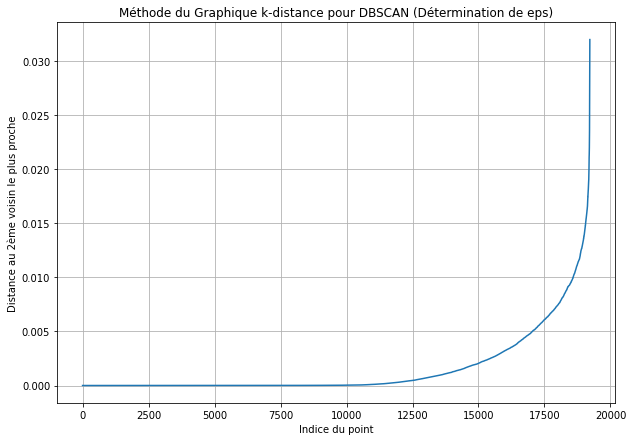

In [17]:
# Utilisez la méthode du Graphique k-distance pour déterminer la valeur optimale de eps
nbrs = NearestNeighbors(n_neighbors=10).fit(data_kpca_reduced)
distances, indices = nbrs.kneighbors(data_kpca_reduced)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]  # Utilisez la distance au 2ème voisin le plus proche pour une meilleure granularité

# Tracez le graphique des distances moyennes en fonction de k
plt.figure(figsize=(10, 7))
plt.plot(distances)
plt.xlabel('Indice du point')
plt.ylabel('Distance au 2ème voisin le plus proche')
plt.title('Méthode du Graphique k-distance pour DBSCAN (Détermination de eps)')
plt.grid(True)
plt.show()

#### Implémentation avec DBSCAN

Score de silhouette pour DBSCAN avec eps=0.00900: 0.68


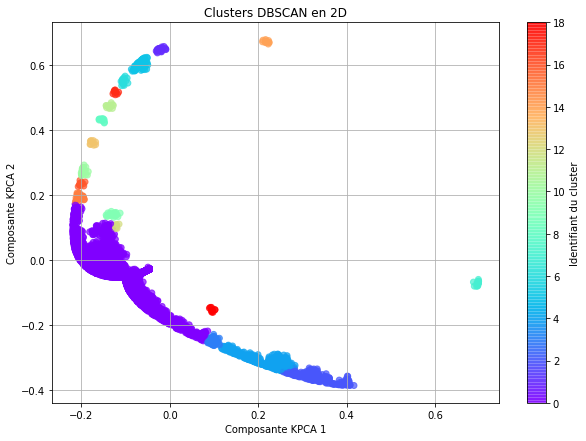

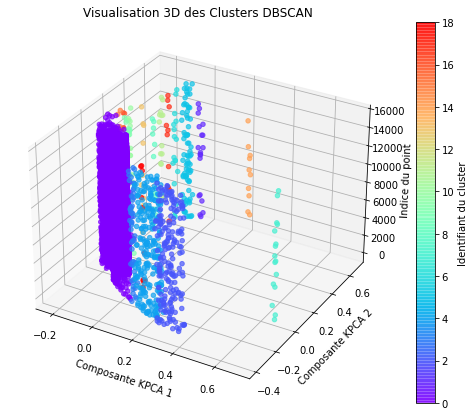

In [18]:
# Estimation d'eps basée sur le graphique k-distance
indice_eps = np.argmax(distances > 0.009)
eps = distances[indice_eps]

# Appliquer DBSCAN avec l'estimation d'eps sur les données réduites par Kernel PCA
dbscan = DBSCAN(eps=eps, min_samples=10)
dbscan_labels = dbscan.fit_predict(data_kpca_reduced)
sample['Cluster_DBSCAN'] = dbscan_labels

# Calculer le score de silhouette
# Ignorer le bruit en filtrant les labels de cluster égaux à -1
filtered_labels = dbscan_labels[dbscan_labels != -1]
filtered_data = data_kpca_reduced.iloc[dbscan_labels != -1, :]

if len(np.unique(filtered_labels)) > 1:  # Il doit y avoir au moins 2 clusters (hors bruit) pour calculer le score
    silhouette_avg = silhouette_score(filtered_data, filtered_labels)
    print(f'Score de silhouette pour DBSCAN avec eps={eps:.5f}: {silhouette_avg:.2f}')
else:
    print("DBSCAN n'a formé que des points de bruit ou un seul cluster, le score de silhouette n'est pas applicable.")

# Visualisation en 2D des clusters DBSCAN
plt.figure(figsize=(10, 7))
plt.scatter(filtered_data.iloc[:, 0], filtered_data.iloc[:, 1], c=filtered_labels, cmap='rainbow', alpha=0.7)
plt.title('Clusters DBSCAN en 2D')
plt.xlabel('Composante KPCA 1')
plt.ylabel('Composante KPCA 2')
plt.colorbar(label='Identifiant du cluster')
plt.grid(True)
plt.show()

# Visualisation en 3D des clusters DBSCAN
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d') 
indices = np.arange(len(filtered_data))
sc = ax.scatter(filtered_data.iloc[:, 0], filtered_data.iloc[:, 1], indices, c=filtered_labels, cmap='rainbow', alpha=0.7)
ax.set_title('Visualisation 3D des Clusters DBSCAN')
ax.set_xlabel('Composante KPCA 1')
ax.set_ylabel('Composante KPCA 2')
ax.set_zlabel('Indice du point')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Identifiant du cluster')

plt.show()

#### Interprétation des résultats

L'implémentation de DBSCAN avec une valeur d'eps de 0.009 a conduit à un score de silhouette de 0.68, révélant une distinction notable entre les clusters.

Ce score, bien qu'inférieur à celui observé dans des itérations précédentes de clustering, indique toujours une structure raisonnablement claire des données.

Les visualisations en 2D et en 3D montrent que, bien que les clusters identifiés par DBSCAN ne soient pas aussi nettement définis que ceux issus d'autres méthodes de clustering, ils révèlent néanmoins des groupements de densité qui peuvent être caractéristiques de comportements d'achat distincts parmi les clients d'Olist.

Bien que DBSCAN tende à identifier de nombreux points de bruit, cette caractéristique peut être précieuse pour détecter des outliers ou des clients avec des comportements d'achat atypiques, offrant ainsi des opportunités pour des stratégies de marketing hyper-ciblées.

La capacité de DBSCAN à révéler des clusters basés sur la densité fournit une dimension supplémentaire à l'analyse de segmentation, qui pourrait être exploitée pour des campagnes marketing plus nuancées et personnalisées.

### Choix du model

- Clustering Hiérarchique : Avec un score de silhouette de 0.76, cette méthode a révélé des clusters bien définis et une structure de données claire. Cependant, la visualisation des clusters a montré une certaine dispersion, ce qui peut poser des défis pour l'interprétation.

- K-Means : Ce modèle a donné un score de silhouette de 0.78, légèrement supérieur à celui du Clustering Hiérarchique, et a produit des clusters distincts qui sont faciles à interpréter et à traduire en actions marketing.

- DBSCAN : Avec un score de silhouette de 0.68, DBSCAN a offert une perspective différente, identifiant les zones de densité et isolant les points de bruit. Bien que moins net que les autres méthodes, il offre une segmentation utile pour reconnaître des comportements uniques.

Après mûre réflexion, nous avons décidé de choisir K-Means comme notre modèle de clustering pour la segmentation client.

Cette décision est motivée par la combinaison du score de silhouette élevé, de l'interprétabilité des clusters et de la facilité d'application des résultats aux stratégies marketing.

Les clusters formés par K-Means sont bien équilibrés et clairement délimités, facilitant ainsi l'identification des segments de clients et leur caractérisation pour des actions ciblées.

En conclusion, K-Means offre la clarté et la structure requises pour avancer avec confiance dans la segmentation RFM, qui permettra à Olist de mettre en œuvre des initiatives de marketing précises et efficaces.

### Segmentation RFM 

#### Ajoute des clusters dans notre dataframe échantillon

In [19]:
# Ajoutez les labels de clustering K-Means comme une nouvelle colonne dans 'sample'
sample['Cluster_KMeans'] = kmeans_labels

In [20]:
sample.head()

,customer_unique_id,Recency,Frequency,Rising,Review_average,Importance_False,Importance_True,Cluster_HC,Cluster_KMeans,Cluster_DBSCAN
74397,c60c5563690f2a27a76f4d8ba53c2a85,-0.222222,0.0,-0.544971,0.0,1.0,0.0,3,2,-1
45823,79d64050de51f4f2c5280e88ba96c864,0.854701,0.0,0.492401,-2.0,1.0,0.0,2,0,0
44830,77426f7a06e493a618f5eec875ee7450,0.329060,0.0,0.006395,0.0,1.0,0.0,0,0,-1
19856,34b02e69444e6e159c83d7d6936fb216,0.128205,0.0,-0.216012,-1.0,1.0,0.0,2,0,0
42974,72257c3a06b3f5851d40c70240f4e322,0.799145,0.0,-0.212607,0.0,1.0,0.0,2,0,0


#### Calcul de la segmentation RFM

Dans le cadre de notre mission actuelle avec Olist, nous abordons la segmentation des clients avec un double objectif.

Tout d'abord, nous visons à créer une segmentation globale qui englobe l'ensemble de la base de données clients. 

Cette approche macroscopique nous permettra d'avoir une vue d'ensemble sur la diversité et la répartition de tous nos clients.

Cependant, nous reconnaissons également la nécessité d'une focalisation spécifique sur les segments de clients les plus actifs.

Comme indiqué par notre client, seuls 3 % de la base de données ont effectué plusieurs commandes.

Bien que minoritaires, ces clients actifs sont d'une importance capitale pour l'entreprise en raison de leur potentiel de fidélisation et de leur contribution significative au chiffre d'affaires.

Par conséquent, une segmentation détaillée de ce sous-groupe est essentielle pour une stratégie de marketing ciblée et efficace.

Pour assurer la continuité et la cohérence avec les travaux antérieurs, nous adopterons la même nomenclature de segmentation RFM utilisée par notre prédécesseur.

Les segments tels que "Champions", "Loyaux", "Loyalistes potentiels", "À réactiver" et "À risque" seront utilisés. 

Cette décision stratégique permettra à l'équipe marketing d'Olist d'aligner facilement nos nouvelles découvertes avec les données historiques et d'exploiter pleinement les segments existants dans leurs campagnes actuelles et futures.

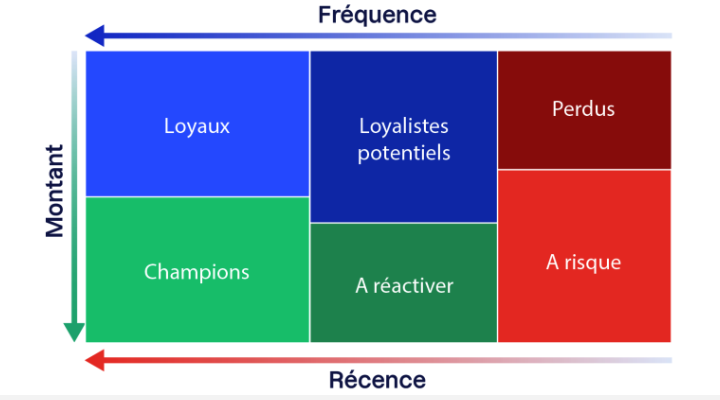

In [21]:
print(sample.head())

                     customer_unique_id   Recency  Frequency    Rising  \
74397  c60c5563690f2a27a76f4d8ba53c2a85 -0.222222        0.0 -0.544971   
45823  79d64050de51f4f2c5280e88ba96c864  0.854701        0.0  0.492401   
44830  77426f7a06e493a618f5eec875ee7450  0.329060        0.0  0.006395   
19856  34b02e69444e6e159c83d7d6936fb216  0.128205        0.0 -0.216012   
42974  72257c3a06b3f5851d40c70240f4e322  0.799145        0.0 -0.212607   

       Review_average  Importance_False  Importance_True  Cluster_HC  \
74397             0.0               1.0              0.0           3   
45823            -2.0               1.0              0.0           2   
44830             0.0               1.0              0.0           0   
19856            -1.0               1.0              0.0           2   
42974             0.0               1.0              0.0           2   

       Cluster_KMeans  Cluster_DBSCAN  
74397               2              -1  
45823               0               0  
44

In [22]:
# Calcul des quantiles pour 'Recency'
sample['Recency_Quantile'] = pd.qcut(sample['Recency'], q=5, labels=range(5, 0, -1), duplicates='drop')

# Trouvez le nombre réel de quantiles pour 'Frequency'
unique_bins_frequency = pd.qcut(sample['Frequency'], q=5, duplicates='drop').unique()
num_unique_bins_frequency = len(unique_bins_frequency)

# Calcul des quantiles pour 'Frequency' avec le nombre de labels correspondant
frequency_labels = range(1, num_unique_bins_frequency + 1)
sample['Frequency_Quantile'] = pd.qcut(sample['Frequency'], q=5, labels=frequency_labels, duplicates='drop')

# Répétez le processus pour 'Rising' (valeur monétaire)
unique_bins_monetary = pd.qcut(sample['Rising'], q=5, duplicates='drop').unique()
num_unique_bins_monetary = len(unique_bins_monetary)

monetary_labels = range(1, num_unique_bins_monetary + 1)
sample['Monetary_Quantile'] = pd.qcut(sample['Rising'], q=5, labels=monetary_labels, duplicates='drop')

# Imprimez le résultat pour vérification
print(f'Unique bins for Frequency: {unique_bins_frequency}')
print(f'Unique bins for Rising: {unique_bins_monetary}')
print(sample[['Recency_Quantile', 'Frequency_Quantile', 'Monetary_Quantile']].head())

Unique bins for Frequency: [(-0.001, 8.0]]
Categories (1, interval[float64]): [(-0.001, 8.0]]
Unique bins for Rising: [(-0.814, -0.439], (0.212, 0.843], (-0.171, 0.212], (-0.439, -0.171], (0.843, 56.592]]
Categories (5, interval[float64]): [(-0.814, -0.439] < (-0.439, -0.171] < (-0.171, 0.212] < (0.212, 0.843] < (0.843, 56.592]]
      Recency_Quantile Frequency_Quantile Monetary_Quantile
74397                4                  1                 1
45823                1                  1                 4
44830                2                  1                 3
19856                3                  1                 2
42974                1                  1                 2


##### Segmentation globale

In [23]:
# Puisque tous les clients sont dans le même quantile pour 'Frequency', 
# nous pouvons simplement les considérer tous comme ayant le même score pour cette métrique.
sample['Frequency_Score'] = 1

# Pour 'Recency' et 'Monetary', nous utilisons les quantiles calculés précédemment.
sample['Recency_Score'] = sample['Recency_Quantile']
sample['Monetary_Score'] = sample['Monetary_Quantile']

# Définition des segments RFM en fonction des scores
def assign_rfm_segment(row):
    if row['Recency_Score'] >= 4 and row['Frequency_Score'] == 1 and row['Monetary_Score'] >= 4:
        return "Champions"
    elif row['Recency_Score'] >= 4 and row['Frequency_Score'] == 1:
        return "Loyaux"
    elif row['Recency_Score'] <= 2 and row['Frequency_Score'] == 1 and row['Monetary_Score'] >= 4:
        return "Loyalistes potentiels"
    elif row['Recency_Score'] <= 2 and row['Frequency_Score'] == 1:
        return "À réactiver"
    else:
        return "À risque"

# Appliquer la fonction d'attribution des segments RFM
sample['RFM_Segment'] = sample.apply(assign_rfm_segment, axis=1)

# Vérification des segments RFM
sample[['Recency_Score', 'Frequency_Score', 'Monetary_Score', 'RFM_Segment']].head()

,Recency_Score,Frequency_Score,Monetary_Score,RFM_Segment
74397,4,1,1,Loyaux
45823,1,1,4,Loyalistes potentiels
44830,2,1,3,À réactiver
19856,3,1,2,À risque
42974,1,1,2,À réactiver


***Visualisation des segment par rapport au clusters***

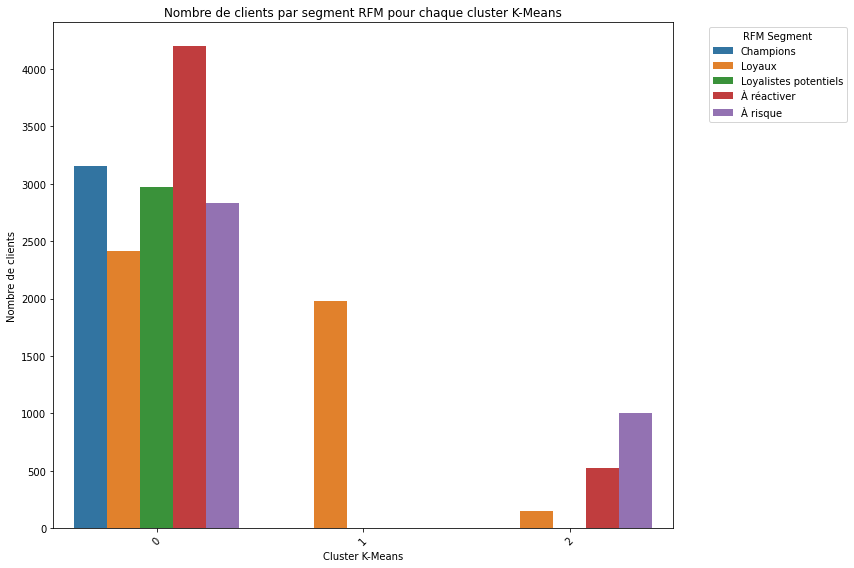

In [24]:
# Analyse des segments RFM pour chaque cluster
cluster_rfm_analysis = sample.groupby(['Cluster_KMeans', 'RFM_Segment']).size().reset_index(name='Count')

# Tri des segments RFM dans l'ordre spécifié
rfm_segments_order = ["Champions", "Loyaux", "Loyalistes potentiels", "À réactiver", "À risque"]
cluster_rfm_analysis['RFM_Segment'] = pd.Categorical(cluster_rfm_analysis['RFM_Segment'], categories=rfm_segments_order, ordered=True)
cluster_rfm_analysis.sort_values(by=['Cluster_KMeans', 'RFM_Segment'], inplace=True)

# Visualisation du nombre de clients de chaque segment pour chaque cluster
plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster_KMeans', y='Count', hue='RFM_Segment', data=cluster_rfm_analysis)
plt.title('Nombre de clients par segment RFM pour chaque cluster K-Means')
plt.xlabel('Cluster K-Means')
plt.ylabel('Nombre de clients')
plt.xticks(rotation=45)
plt.legend(title='RFM Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

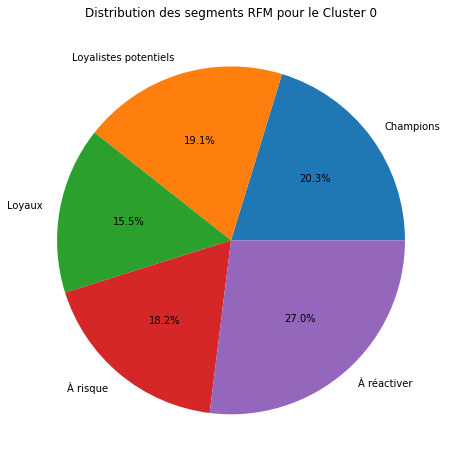

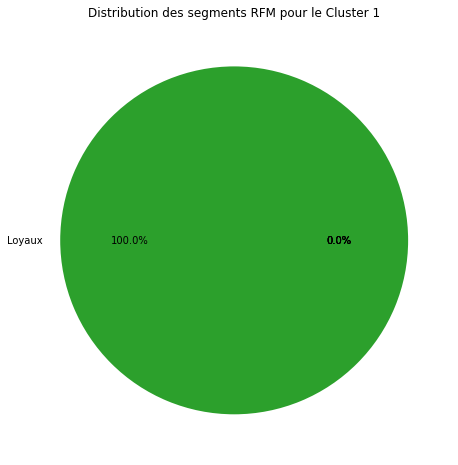

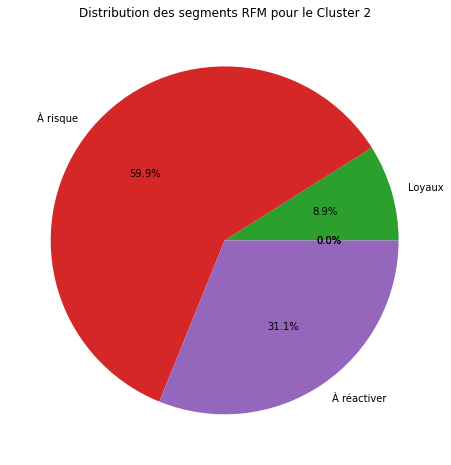

In [25]:
# Regrouper les données par cluster et segment RFM, calculer les comptes
cluster_rfm_counts = sample.groupby(['Cluster_KMeans', 'RFM_Segment']).size().unstack(fill_value=0)

# Calculer les pourcentages de chaque segment par cluster
cluster_rfm_percentages = cluster_rfm_counts.divide(cluster_rfm_counts.sum(axis=1), axis=0)

# Afficher un graphique en camembert pour chaque cluster
for cluster in cluster_rfm_percentages.index:
    plt.figure(figsize=(8, 8))
    cluster_rfm_percentages.loc[cluster].plot.pie(autopct='%1.1f%%')
    plt.title(f'Distribution des segments RFM pour le Cluster {cluster}')
    plt.ylabel('')
    plt.show()

##### Segmentation globale focalisation spécifique sur les 3 %

/home/nexus/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


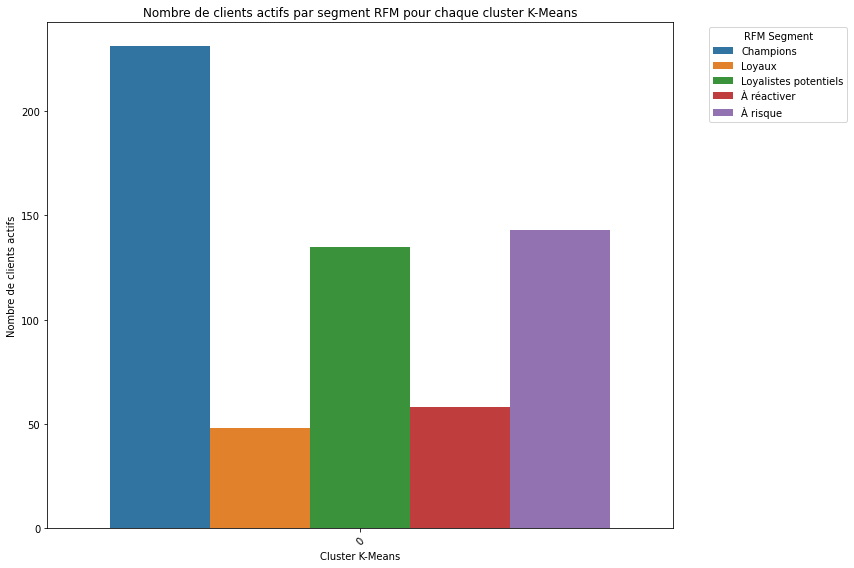

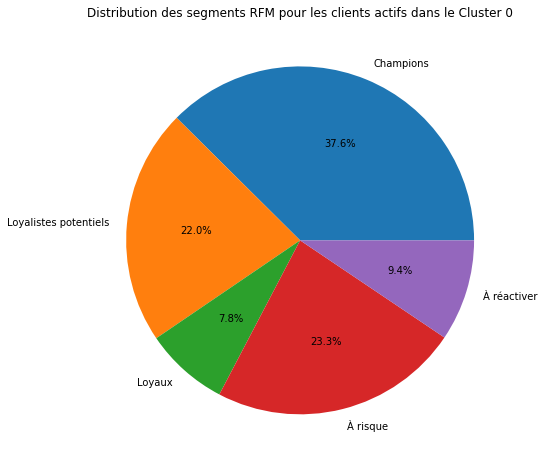

In [26]:
# Filtrer pour les 3 % les plus actifs
active_customers = sample[sample['Importance_True'] == 1]

# Appliquer la même fonction d'attribution des segments RFM aux clients actifs
active_customers['RFM_Segment'] = active_customers.apply(assign_rfm_segment, axis=1)

# Vérifier les segments RFM des clients actifs
active_customers[['Recency_Score', 'Frequency_Score', 'Monetary_Score', 'RFM_Segment']].head()

# Analyse des segments RFM pour les clients actifs dans chaque cluster
active_cluster_rfm_analysis = active_customers.groupby(['Cluster_KMeans', 'RFM_Segment']).size().reset_index(name='Count')

# Trier les segments RFM pour les clients actifs dans l'ordre spécifié
active_cluster_rfm_analysis['RFM_Segment'] = pd.Categorical(active_cluster_rfm_analysis['RFM_Segment'], categories=rfm_segments_order, ordered=True)
active_cluster_rfm_analysis.sort_values(by=['Cluster_KMeans', 'RFM_Segment'], inplace=True)

# Visualisation du nombre de clients actifs de chaque segment pour chaque cluster
plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster_KMeans', y='Count', hue='RFM_Segment', data=active_cluster_rfm_analysis)
plt.title('Nombre de clients actifs par segment RFM pour chaque cluster K-Means')
plt.xlabel('Cluster K-Means')
plt.ylabel('Nombre de clients actifs')
plt.xticks(rotation=45)
plt.legend(title='RFM Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculer les pourcentages des segments RFM pour les clients actifs dans chaque cluster
active_cluster_rfm_counts = active_customers.groupby(['Cluster_KMeans', 'RFM_Segment']).size().unstack(fill_value=0)
active_cluster_rfm_percentages = active_cluster_rfm_counts.divide(active_cluster_rfm_counts.sum(axis=1), axis=0)

# Afficher un graphique en camembert pour les clients actifs dans chaque cluster
for cluster in active_cluster_rfm_percentages.index:
    plt.figure(figsize=(8, 8))
    active_cluster_rfm_percentages.loc[cluster].plot.pie(autopct='%1.1f%%')
    plt.title(f'Distribution des segments RFM pour les clients actifs dans le Cluster {cluster}')
    plt.ylabel('')
    plt.show()

## Présentation des résultats

L'analyse RFM segmentée par clusters K-Means a permis de révéler des insights distincts sur la base de clientèle :

- **Cluster 0** - Potentiel Diversifié : Ce cluster se caractérise par une répartition équilibrée des segments RFM, avec une présence notable de "Champions" et de clients "À réactiver". Cela suggère une opportunité d'engagement à travers des stratégies de rétention et de réactivation.



- **Cluster 1** - Loyauté Uniforme : Dominé exclusivement par des clients "Loyaux", ce cluster pourrait représenter une base de clients fidèles et constants. Des initiatives de marketing pourraient se concentrer sur la valorisation de cette loyauté et l'augmentation de la valeur client à long terme.



- **Cluster 2** - Risque Élevé : Avec une majorité de clients "À risque", ce cluster semble contenir des clients nécessitant une attention immédiate pour éviter le churn. Des campagnes de réengagement et des offres spéciales pourraient être utilisées pour améliorer la récence et la fréquence de leurs interactions.


Notre focalisation sur les 3 % les plus actifs a révélé des patterns de comportement qui sont essentiels pour le ciblage précis.

Les segments de "Champions", "Loyalistes potentiels", et même les clients "À risque" parmi ce groupe actif offrent une opportunité d'optimiser les stratégies de marketing et de communication pour accroître l'engagement et la conversion.